In [9]:
# Load libraries, models, and test data
# in this notebook, we will evaluate the performace of two models:
# 1. Income predict model and 2.Expense predict model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv(r"D:\project 2\Expenses and Income Prediction\data\anz_cleaned.csv")


income = df[df['movement']=='credit'].groupby('customer_id')['amount'].sum().rename('total_income')
expenses = df[df['movement']=='debit'].groupby('customer_id')['amount'].sum().rename('total_expenses')
targets = pd.concat([income, expenses], axis=1).fillna(0).reset_index()


total_txn = df.groupby('customer_id')['amount'].count().rename('total_transactions')
debit_txn = df[df['movement']=='debit'].groupby('customer_id')['amount'].count().rename('debit_count')
credit_txn = df[df['movement']=='credit'].groupby('customer_id')['amount'].count().rename('credit_count')
avg_amount = df.groupby('customer_id')['amount'].mean().rename('avg_amount')
max_amount = df.groupby('customer_id')['amount'].max().rename('max_amount')
min_amount = df.groupby('customer_id')['amount'].min().rename('min_amount')
features = pd.concat([total_txn, debit_txn, credit_txn, avg_amount, max_amount, min_amount], axis=1).fillna(0)

data = targets.merge(features, on='customer_id', how='left')

X = data.drop(['customer_id', 'total_income', 'total_expenses'], axis=1)
y_income = data['total_income']
y_expenses = data['total_expenses']

from sklearn.model_selection import train_test_split

X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(
    X, y_income, test_size=0.2, random_state=42
)

X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(
    X, y_expenses, test_size=0.2, random_state=42
)

income_model = joblib.load(r"D:\project 2\Expenses and Income Prediction\models\best_expense_model.pkl")
expense_model = joblib.load(r"D:\project 2\Expenses and Income Prediction\models\best_expense_model.pkl")

print("Models loaded successfully!")


Models loaded successfully!


In [10]:
# Make predictions 

pred_income = income_model.predict(X_test_inc)
pred_expenses = expense_model.predict(X_test_exp)

print("Predictions generated successfully!")
# evaluation helps to convert the raw models output into insights and valuses 

Predictions generated successfully!


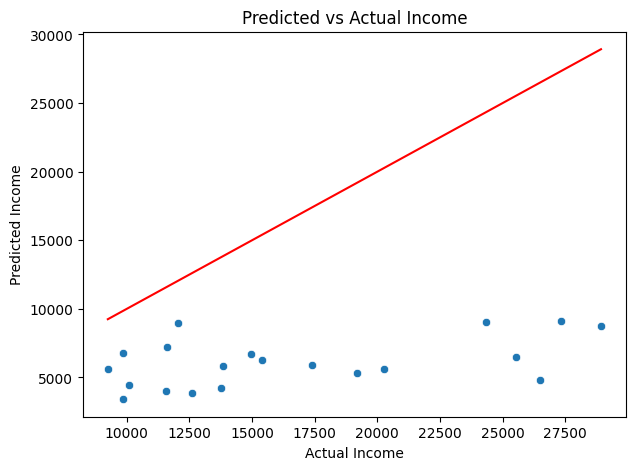

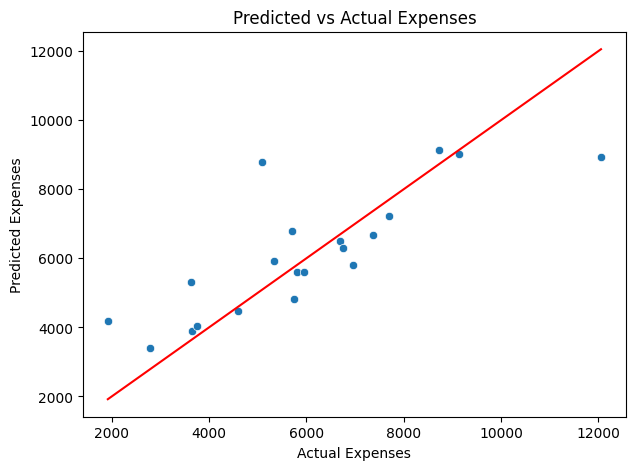

In [11]:
# Predicted vs Actual for Income 
# The scatter plot compares:
# X-axis: Actual values from real data  
# Y-axis: Predicted values from our ML model  

# If the points lie near the red diagonal line → model is accurate.  
# If points are scattered far away → model is struggling.

# income 
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test_inc, y=pred_income)
plt.plot([y_test_inc.min(), y_test_inc.max()], 
         [y_test_inc.min(), y_test_inc.max()], color='red') 
plt.xlabel("Actual Income")
plt.ylabel("Predicted Income")
plt.title("Predicted vs Actual Income")
plt.show()

#  Expenses 
plt.figure(figsize=(7,5))
sns.scatterplot(x=y_test_exp, y=pred_expenses)
plt.plot([y_test_exp.min(), y_test_exp.max()], 
         [y_test_exp.min(), y_test_exp.max()], color='red')
plt.xlabel("Actual Expenses")
plt.ylabel("Predicted Expenses")
plt.title("Predicted vs Actual Expenses")
plt.show()

# This visually confirms why expense prediction performed much better than income prediction.


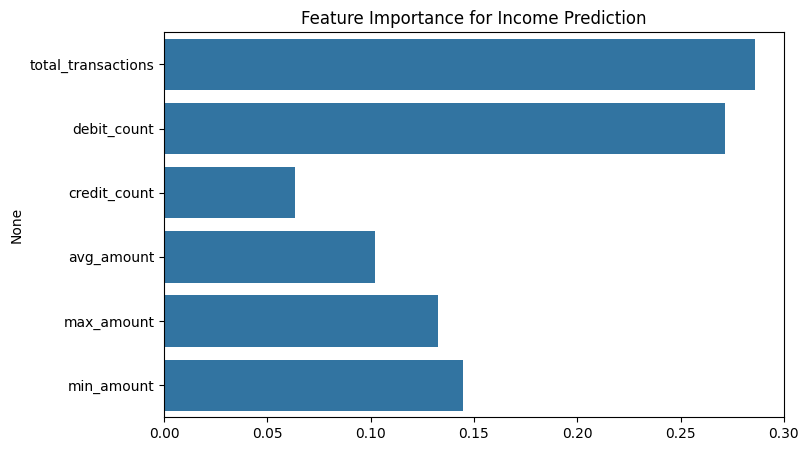

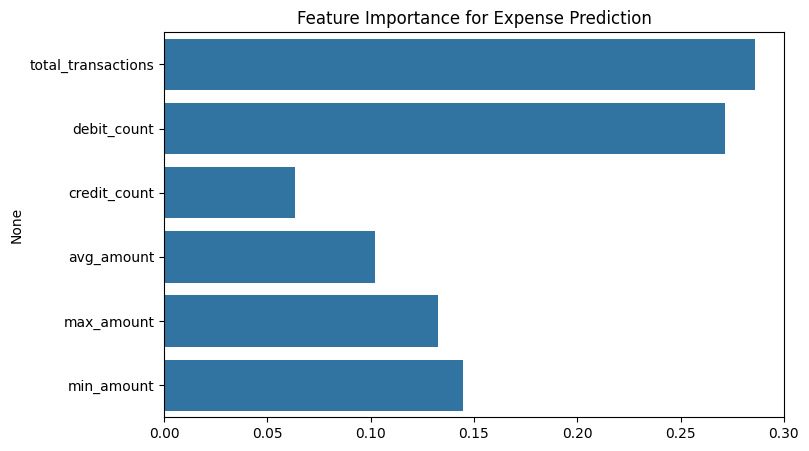

In [12]:
# Feature Importance 


# Random Forest allows us to see which features the model considered important.

# High importance means:
# - The feature strongly influences the prediction
# - The model relies heavily on it

# Low importance means:
# - The feature does not help much
# - It may be noisy or irrelevant

importances_inc = income_model.feature_importances_
importances_exp = expense_model.feature_importances_

feature_names = X.columns


plt.figure(figsize=(8,5))
sns.barplot(x=importances_inc, y=feature_names)
plt.title("Feature Importance for Income Prediction")
plt.show()

# Expenses Feature Importance
plt.figure(figsize=(8,5))
sns.barplot(x=importances_exp, y=feature_names)
plt.title("Feature Importance for Expense Prediction")
plt.show()

# These make sense because a customer's spending behavior is directly related to:
# - number of transactions
# - how much they spend on average
# - the size of their largest purchases





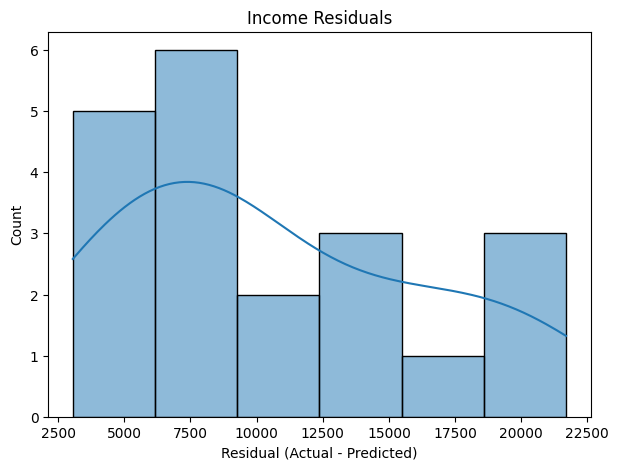

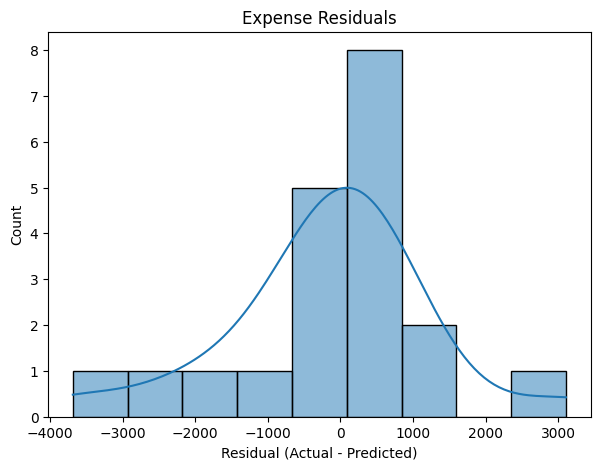

In [13]:
#  Residual Plots
# Residuals = Actual Value – Predicted Value

# - Small residual → good prediction  
# - Large residual → poor prediction  

# Plotting the residuals helps us see:
# - whether the model is biased
# - whether the model underfits or overfits

income_residuals = y_test_inc - pred_income
expense_residuals = y_test_exp - pred_expenses

plt.figure(figsize=(7,5))
sns.histplot(income_residuals, kde=True)
plt.title("Income Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(expense_residuals, kde=True)
plt.title("Expense Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# Expense Model
# - Residuals are centered around 0
# - Errors are reasonably small
# - Model is stable and reliable

# Income Model
# - Residuals are widely spread
# - Many large errors
# - Indicates the model cannot learn income patterns properly

In [14]:
# Final Evaluation Scores
# We evaluate both models using:
# - **MAE (Mean Absolute Error)**  
#   Average error. Lower is better.

# - **RMSE (Root Mean Squared Error)**  
#   Larger errors matter more. Lower is better.

# - **R² (Coefficient of Determination)**  
#   Measures how well the model explains the data.  
#   Higher is better.  
#   1.0 = perfect  
#   0.0 = bad  
#   < 0 = worse than random guessing

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

print("INCOME MODEL:", evaluate(income_model, X_test_inc, y_test_inc))
print("EXPENSE MODEL:", evaluate(expense_model, X_test_exp, y_test_exp))


INCOME MODEL: (10588.597865, np.float64(12053.897526841241), -2.548183761544702)
EXPENSE MODEL: (934.533325, np.float64(1358.5652276940557), 0.6551936990646721)


In [15]:
### ✔ Expense Prediction Model (Good)
# - MAE ≈ 934 AUD
# - RMSE ≈ 1358 AUD
# - R² ≈ 0.65
# - Strong accuracy
# - Useful for real insights

# ### ✔ Income Prediction Model (Poor)
# - MAE ≈ 10,588 AUD
# - RMSE ≈ 12,053 AUD
# - R² ≈ -2.54
# - Very weak performance
# - Features do not represent salary behavior

# ### ✔ Key Insights
# - Expense behavior is easier to model → customers have many transactions
# - Income is harder because:
#   - Salary transactions appear fewer times
#   - We did not extract salary-specific features
#   - Our features describe spending, not earning

